<a href="https://colab.research.google.com/github/Suryalokesh84/FMML_ASSIGNMENTS_AND_LABS/blob/main/Module_9_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-19 15:51:36--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.77, 18.160.200.112, 18.160.200.71, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   124MB/s    in 0.4s    

2024-05-19 15:51:37 (124 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


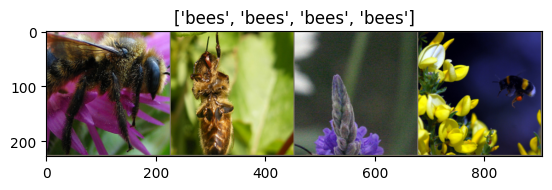

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.5MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5795 Acc: 0.7295

Epoch 1/4
----------
Loss: 0.3382 Acc: 0.8648

Epoch 2/4
----------
Loss: 0.5436 Acc: 0.7295

Epoch 3/4
----------
Loss: 0.4873 Acc: 0.7992

Epoch 4/4
----------
Loss: 0.4927 Acc: 0.8074



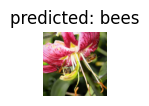

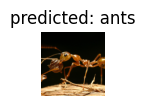

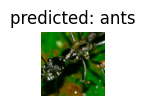

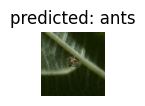

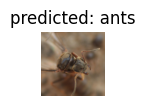

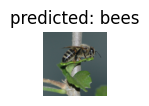

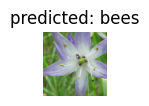

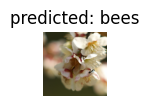

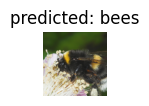

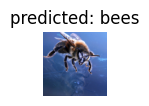

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


#**ANSWERS**

#**1.Answer.::**

Data augmentations such as resizing, cropping, flipping, rotating, and other transformations are significant in training machine learning models, especially in the context of computer vision, for several key reasons:



**1.Increased Training Data:** Augmentations effectively increase the size of the training dataset without requiring the collection of new data. By applying different transformations to the existing data, the model can see multiple variations of each example, which helps it learn more robust features.

**2.Improved Generalization:** Augmentations introduce variability into the training data, helping the model to generalize better to new, unseen data. This reduces overfitting, where the model performs well on the training data but poorly on test or real-world data.

**3.Simulating Real-World Variations:** In real-world applications, data can come in various forms and conditions. Augmentations like resizing, cropping, rotation, and color adjustments simulate these variations, making the model more adaptable to different scenarios it might encounter in practice.

**4.Enhanced Robustness:** By training on augmented data, the model becomes more robust to noise and perturbations. For example, random cropping or resizing can make the model invariant to different object scales and positions within an image, while flipping can help with orientation invariance.

**5.Balance and Diversity:** Augmentations can help balance the dataset if there are biases or imbalances. For instance, if certain classes have fewer examples, augmentations can generate more varied examples for those classes, helping to balance the training process.

**6.Better Feature Learning:** Data augmentations encourage the model to focus on learning more meaningful and generalizable features rather than memorizing specific details of the training images. This leads to a more powerful and effective feature representation in the learned model.

#**Common Data Augmentations and Their Benefits:**
* **Resizing:** Alters the size of the image. Helps the model handle images of varying resolutions and scales.
* **Cropping:** Extracts sub-regions of the image. Introduces scale and position variance, helping the model learn to detect objects in various positions and sizes.
* **Flipping (Horizontal/Vertical):** Mirrors the image. Useful for learning invariance to orientation, especially in cases where orientation does not affect the object class.
* **Rotation:** Rotates the image by a random angle. Helps the model be invariant to rotational changes.
* **Color Jittering:** Randomly changes the brightness, contrast, saturation, and hue. Helps the model be robust to color variations and lighting conditions.
* **Zooming:** Either zooms in or out of the image. Similar to cropping, it helps with scale invariance.
* **Noise Addition:** Adds random noise to the image. Makes the model more robust to noisy data and enhances its ability to extract relevant features.


#**2.Answer.::**

Training a ResNet model from scratch (i.e., without using pretrained weights) typically results in lower performance compared to starting with a pretrained model. Here are some key points to consider regarding the performance differences:

#**Performance Impact:**

- **1.Accuracy**: Training from scratch usually yields lower initial accuracy. Pretrained models start with weights that have already learned useful features from a large dataset (like ImageNet), which significantly boosts their performance on new tasks with fewer training epochs.

* **2.Training Time:** Training a model from scratch takes considerably more time. Pretrained models converge faster because they start with weights that are already in a good state for feature extraction, whereas scratch models need to learn these features from the ground up.

* **3.Computational Resources:** Training from scratch requires more computational resources. You need more epochs, and thus more time and hardware, to reach comparable performance levels to a pretrained model.

* **4.Data Requirements:** Models trained from scratch generally need more data to achieve good performance. Pretrained models leverage the features learned from large datasets, which is particularly advantageous when you have a limited amount of data.

#**Typical Results:**

When using a pretrained ResNet model, the network starts with weights that have been fine-tuned on a large and diverse dataset. This provides a strong starting point for the model, often leading to higher accuracy and faster convergence. Here’s a general comparison:

* **1.Pretrained Model:**

  * **Initial Accuracy:** Higher
  * **Convergence Speed:** Faster
  * **Final Accuracy:** Higher (with fewer epochs)
  * **Data Efficiency**: High
* **2.Training from Scratch:**

  * **Initial Accuracy:** Lower
  * **Convergence Speed:** Slower
  * **Final Accuracy:** Lower (requires more epochs)
  * **Data Efficiency:** Low (needs more data)

#**Example Scenario:**
Suppose you are training a ResNet-50 model on a specific dataset. If you use a pretrained ResNet-50 model, you might reach, for example, 85% accuracy in 10 epochs. On the other hand, if you train the same ResNet-50 model from scratch (pretrained=False), you might only reach 60% accuracy after 10 epochs, and it could take 50 or more epochs to reach similar accuracy to the pretrained model, depending on the size and complexity of your dataset.

#**Practical Considerations:**

* **Use Pretrained Models for Transfer Learning:** For most applications, especially when you have limited data, using a pretrained model is recommended. You can fine-tune it on your specific task, benefiting from the rich feature representations learned from large-scale datasets.
* **Training from Scratch for Novel Tasks:** In cases where your dataset is vastly different from the datasets used for pretraining (e.g., medical imaging, satellite imagery), or if you want to explore novel architectures, training from scratch might be necessary despite the increased resource requirements.

#**3.Answer.:**
Using a pretrained ResNet model on a dataset that is significantly different from the one it was originally trained on can still provide performance benefits, but the extent of these benefits can vary based on several factors:

# **Factors Affecting Performance:**
* **1.Similarity of Features:** Even if the source dataset (the one used for pretraining) is different, the model can still transfer useful low-level features like edges, textures, and shapes. These features are often general enough to be useful across a variety of tasks.

* **2.Task Similarity:** If the pretraining task (e.g., image classification) is similar to the target task (e.g., another image classification problem), the pretrained model can adapt more easily. If the tasks are very different (e.g., pretraining on object detection and then using for image classification), the benefits might be less pronounced.

* **3.Dataset Size:** The size of the target dataset plays a crucial role. For smaller datasets, using a pretrained model is particularly beneficial as it mitigates the risk of overfitting. For larger datasets, training from scratch might become more feasible.

# **Example Scenario: Ants vs. Bees**

The "Ants vs. Bees" dataset is a relatively simple binary classification problem. Let's consider the impact of using a pretrained model that was trained on a very different dataset:

* **1.Low-Level Feature Transfer:** Pretrained models, such as those trained on ImageNet, have learned to detect basic image features in early layers. These features are likely to be useful even if the target dataset (ants vs. bees) is different from the source dataset (e.g., medical images, satellite images).

* **2.High-Level Feature Adaptation:** Higher-level features in the later layers of the pretrained model might be less relevant if the pretraining dataset is very different. However, fine-tuning the model on the ants vs. bees dataset can help adapt these higher-level features to be more relevant for the new task.

# **Practical Outcomes:**

* **Initial Performance:** Using a pretrained model, even from a very different dataset, will likely result in better initial performance compared to training from scratch. The model starts with useful low-level features and can quickly adapt to the new task.

* **Fine-Tuning Benefits:** Fine-tuning the pretrained model on the ants vs. bees dataset will improve its performance. The model will adjust its weights, especially in the higher layers, to better fit the new data.
#**Specific Results:**
While the exact performance gains depend on the nature of the source and target datasets, some general expectations are:

* **Accuracy Boost:** You will typically see a significant accuracy boost when starting with a pretrained model versus training from scratch.
* **Faster Convergence:** The model will converge faster, needing fewer epochs to reach optimal performance.

#**Example Metrics:**
Suppose a ResNet model pretrained on a significantly different dataset achieves 70% accuracy on the ants vs. bees dataset after fine-tuning. In contrast, training the same model from scratch might start at around 50% accuracy and require more epochs to reach similar or slightly lower accuracy.

#**Conclusion:**
Using a pretrained ResNet model, even if it was trained on a significantly different dataset, generally provides advantages in terms of accuracy and convergence speed. While the high-level features may initially be less relevant, fine-tuning allows the model to adapt to the new dataset effectively, leveraging the useful low-level features learned during pretraining. This approach is especially beneficial for smaller target datasets, where training from scratch could lead to overfitting and poorer performance.







